In [ ]:
# TODO  
# параметры в логи
# label smoothing
# scheduler
# комментарии

In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [44]:
import os
import pandas as pd
import numpy as np
import tqdm
from typing import Tuple
import json 
import gc

import cv2
import PIL 

import torch
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils import generate_labels, ImagenetteDataset, get_norm_stats,\
                    get_transforms, train_procedure, get_augmented_transforms, load_model, plot_models
from models import VGG16, VGG11, VGG_tiny, Resnet, ResnetD, ResNext

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
TRAIN_PATH = 'raw/train'
VAL_PATH = 'raw/val'
TRAIN_LABELS_CSV_PATH = 'raw/train/train_labels.csv'
VAL_LABELS_CSV_PATH = 'raw/val/val_labels.csv'

SAVES_PATH = "saves"

AUGMENT = True

SIZE = 224
batch_size = 16

In [48]:
if 'train_labels.csv' not in os.listdir(TRAIN_PATH):
    generate_labels(TRAIN_PATH, TRAIN_LABELS_CSV_PATH)
if 'val_labels.csv' not in os.listdir(VAL_PATH):
    generate_labels(VAL_PATH, VAL_LABELS_CSV_PATH)

In [5]:
train_labels, val_labels = pd.read_csv(TRAIN_LABELS_CSV_PATH), pd.read_csv(VAL_LABELS_CSV_PATH)
train_labels.head()

,filepath,class_name,class_num
0,raw/train/church/n03028079_10328.JPEG,church,0
1,raw/train/church/n03028079_3583.JPEG,church,0
2,raw/train/church/n03028079_6077.JPEG,church,0
3,raw/train/church/n03028079_3306.JPEG,church,0
4,raw/train/church/n03028079_9356.JPEG,church,0


In [17]:
len(train_labels), len(val_labels)

(9469, 3925)

In [6]:
mean, std = get_norm_stats(TRAIN_LABELS_CSV_PATH)

val_transform = get_transforms(mean, std)
train_transform = get_augmented_transforms(mean, std) if AUGMENT else get_transforms(mean, std)

train_dataset = ImagenetteDataset(TRAIN_LABELS_CSV_PATH, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = ImagenetteDataset(VAL_LABELS_CSV_PATH, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

9


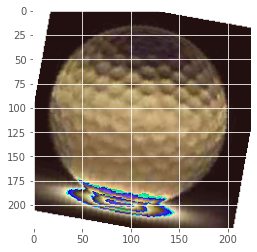

In [21]:
imgs, labels = next(iter(train_dataloader))
transf = T.ToPILImage(mode='RGB')
img = transf(imgs[0])
plt.imshow(img)
print(labels[0].item())

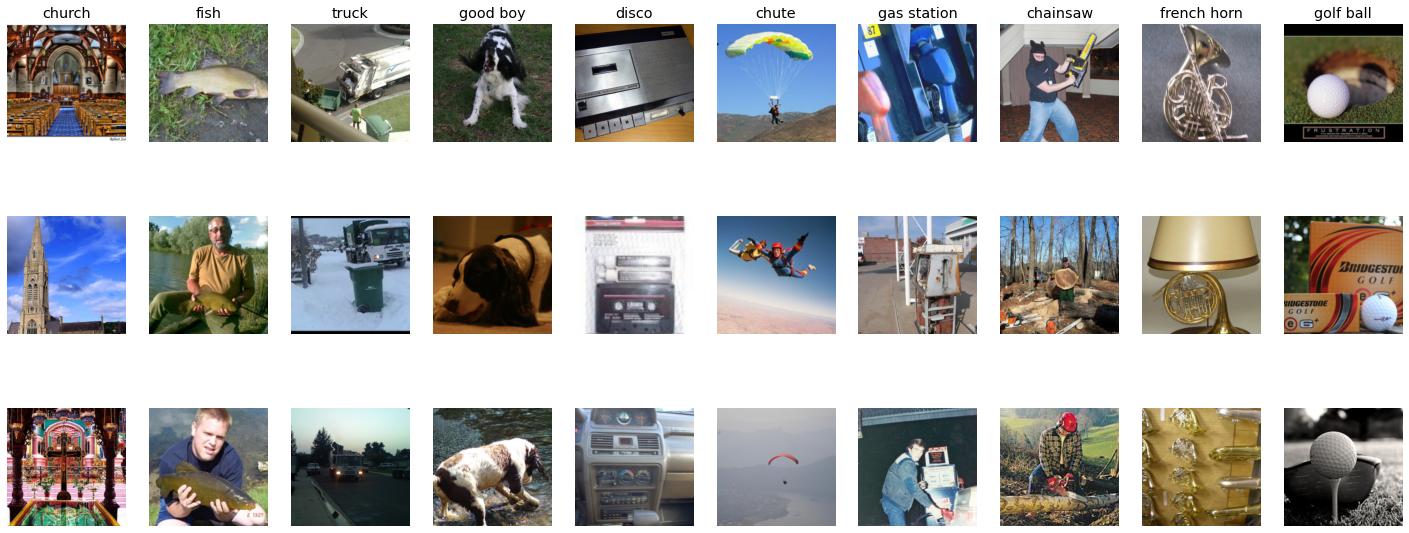

In [22]:
classes = list(train_labels['class_name'].unique())
num_classes = len(classes)
samples_per_class = 3

transform = T.Compose([
    T.Resize(SIZE), 
    T.CenterCrop(SIZE)
])

n_col, n_row = num_classes, samples_per_class
plt.figure(figsize=(25, 10))
for y, label in enumerate(classes):
    ids = np.random.choice(train_labels.loc[train_labels['class_name']==label].index, samples_per_class)
    for i, idx in enumerate(ids):
        img = PIL.Image.open(train_labels.iloc[ids[i]]['filepath'])
        img = transform(img)
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(label)
    

In [22]:
class_names = [name for name in os.listdir(TRAIN_PATH) if name not in ['.ipynb_checkpoints', 'train_labels.csv']]

In [33]:
if 'model' in locals():
    del model
    
N_EPOCHS = 40
RESUME_TRAINING = False

model_name = 'resnet9_aug'
epoch = 0

model = Resnet(num_layers=9)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

if RESUME_TRAINING:
    epoch = load_model(model, optimizer, os.path.join(SAVES_PATH, f'ckpts3/{model_name}_model.pt'))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-8)
model.to(device);

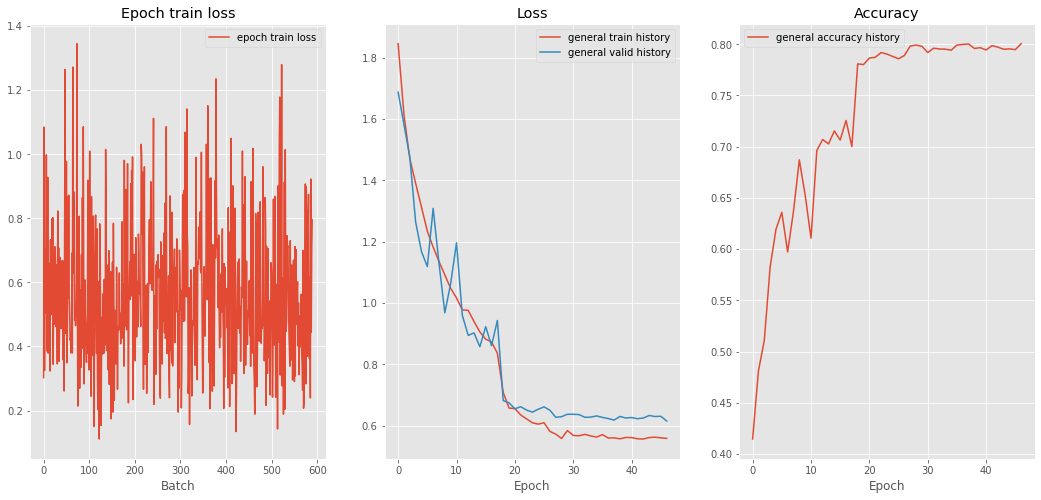

In [15]:
train_procedure(n_epochs=N_EPOCHS, model=model, train_iterator=train_dataloader, 
                val_iterator=val_dataloader, optimizer=optimizer,
                criterion=loss, saves_path=SAVES_PATH, start_epoch=epoch, 
                device=device, scheduler=scheduler, model_name=model_name)

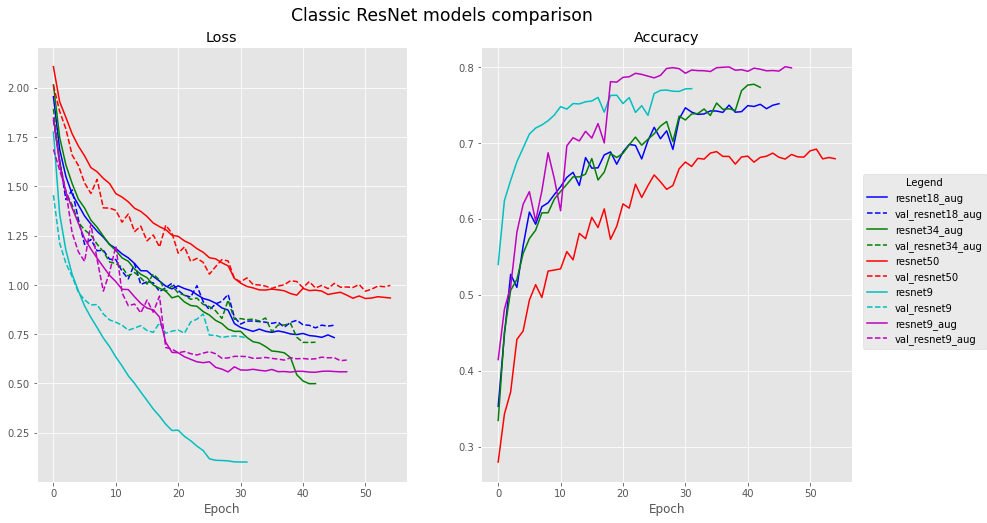

In [41]:
plot_models(['logs_resnet18.json','logs_resnet34.json',
             'logs_resnet50.json', 'logs_resnet9.json', 'logs_resnet9_aug.json'],
            title='Classic ResNet models comparison')

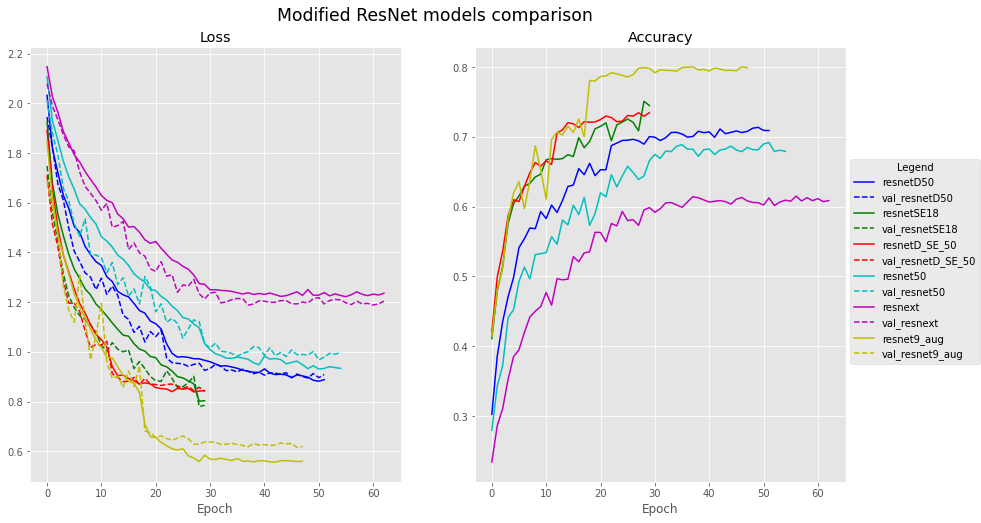

In [123]:
plot_models(['logs_resnetD50.json','logs_resnetSE18.json', 'logs_resnetD_SE_50.json',
             'logs_resnet50.json', 'logs_resnext.json', 'logs_resnet9_aug.json'],
            title='Modified ResNet models comparison')

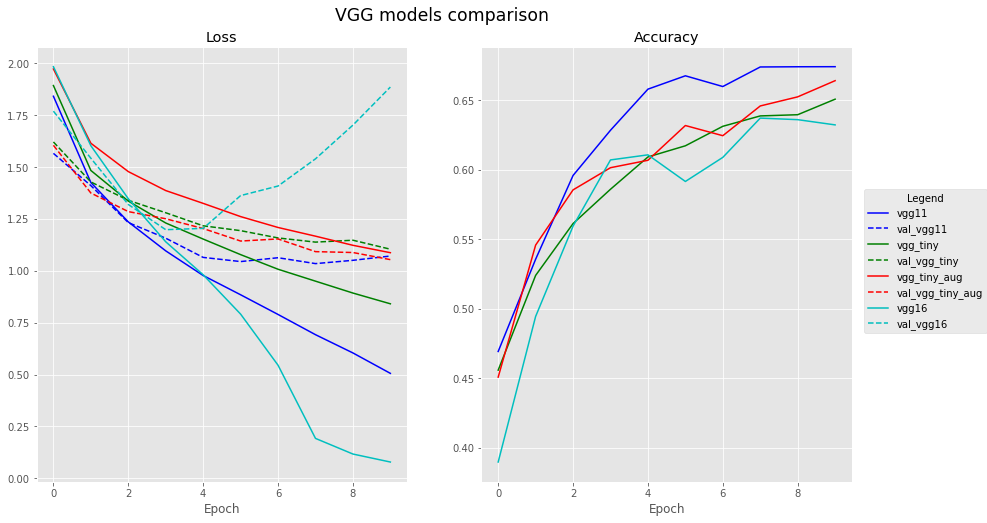

In [17]:
plot_models(['logs_vgg11.json', 'logs_vgg_tiny.json', 'logs_vgg_tiny_aug.json','logs_vgg16.json'],
            title='VGG models comparison')

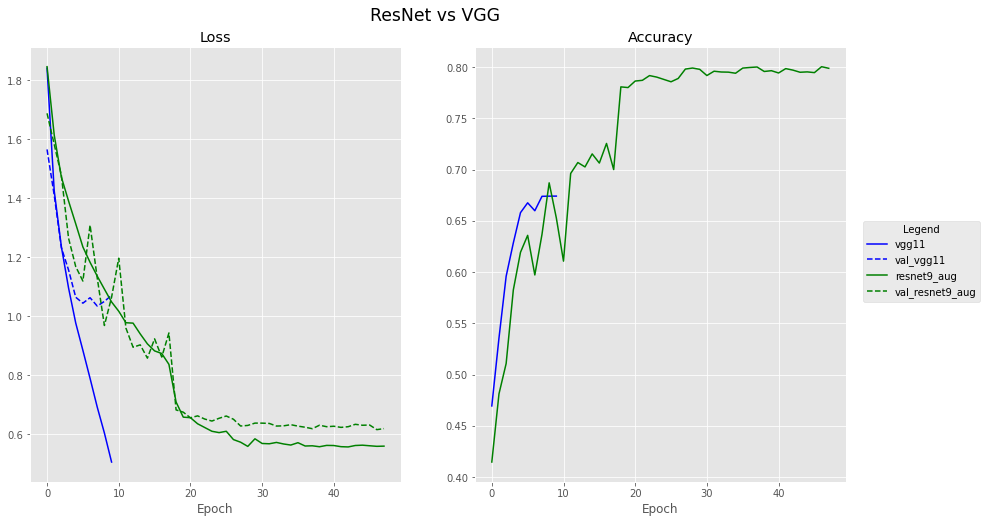

In [18]:
plot_models(['logs_vgg11.json','logs_resnet9_aug.json' ],
            title='ResNet vs VGG')

In [19]:
# best Resnet prediction analysis 
if 'model' in locals():
    del model 
    
model = Resnet(num_layers=9)
ckpt_path = "saves/ckpts3/resnet9_aug_model.pt"
    
checkpoint = torch.load(ckpt_path, device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

model.eval()

class_shot = np.zeros(10)
class_cnt = np.zeros(10)
predictions = np.array([0])
labels_true = np.array([0])
mistake_imgs = {i: [] for i in range(10)}
mistake_preds = {i: [] for i in range(10)}
mistake_labels = {i: [] for i in range(10)}
with torch.no_grad():
    for i, (imgs, labels) in enumerate(val_dataloader):
        imgs = imgs.to(device)
        labels = labels.numpy().astype(int)
        predictions_batch = model(imgs).argmax(axis=1).detach().cpu().numpy().astype(int)
        
        mistake_ids = np.where(labels != predictions_batch)[0]
        if len(mistake_ids) > 0:
            for ind in mistake_ids:
                if len(mistake_imgs[labels[ind]]) < 5:
                    mistake_imgs[labels[ind]].append(imgs[ind].clone().detach().cpu())
                    mistake_labels[labels[ind]].append(labels[ind])
                    mistake_preds[labels[ind]].append(predictions_batch[ind])
        for ind, label in enumerate(labels):
            if label == predictions_batch[ind]:
                class_shot[label] += 1
            class_cnt[label] += 1
            
        predictions = np.concatenate((predictions, predictions_batch), axis=None)
        labels_true = np.concatenate((labels_true, labels), axis=None)
        
predictions, labels_true = predictions[1:], labels_true[1:]
predictions.shape, labels_true.shape, len(mistake_imgs[0]), len(mistake_labels[0]), len(mistake_preds[0])

((3925,), (3925,), 5, 5, 5)

In [20]:
accuracy_score(labels_true, predictions)

0.8

In [23]:
for ind, label in enumerate(class_shot):
    print(f'accuracy of class {class_names[ind]}: {label / class_cnt[ind]}')

accuracy of class church: 0.8337408312958435
accuracy of class fish: 0.9043927648578811
accuracy of class truck: 0.7917737789203085
accuracy of class good boy: 0.8835443037974684
accuracy of class disco: 0.8571428571428571
accuracy of class chute: 0.8512820512820513
accuracy of class gas station: 0.6229116945107399
accuracy of class chainsaw: 0.6580310880829016
accuracy of class french horn: 0.7741116751269036
accuracy of class golf ball: 0.8370927318295739


In [24]:
confusion_matrix(labels_true, predictions)

array([[341,   3,   9,   5,  11,   8,  10,  10,   7,   5],
       [  3, 350,   2,   2,   6,   1,   3,   5,   1,  14],
       [ 14,   4, 308,   2,  10,   3,  19,  17,  10,   2],
       [  5,   6,   6, 349,   1,   2,   2,  12,   2,  10],
       [  5,   0,   7,   4, 306,   2,  16,   6,   9,   2],
       [ 20,   2,   6,   5,   3, 332,   5,   6,   0,  11],
       [ 23,   1,  34,   4,  44,   3, 261,  25,  17,   7],
       [ 20,  12,  12,  12,  24,  10,  21, 254,   6,  15],
       [ 16,   9,   9,   6,  16,   0,  15,  11, 305,   7],
       [ 17,   7,   3,   5,  12,   8,   1,   9,   3, 334]])

/tmp/ipykernel_768/3018092470.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[j, i].imshow(renorm(torch.tensor(images[j])))


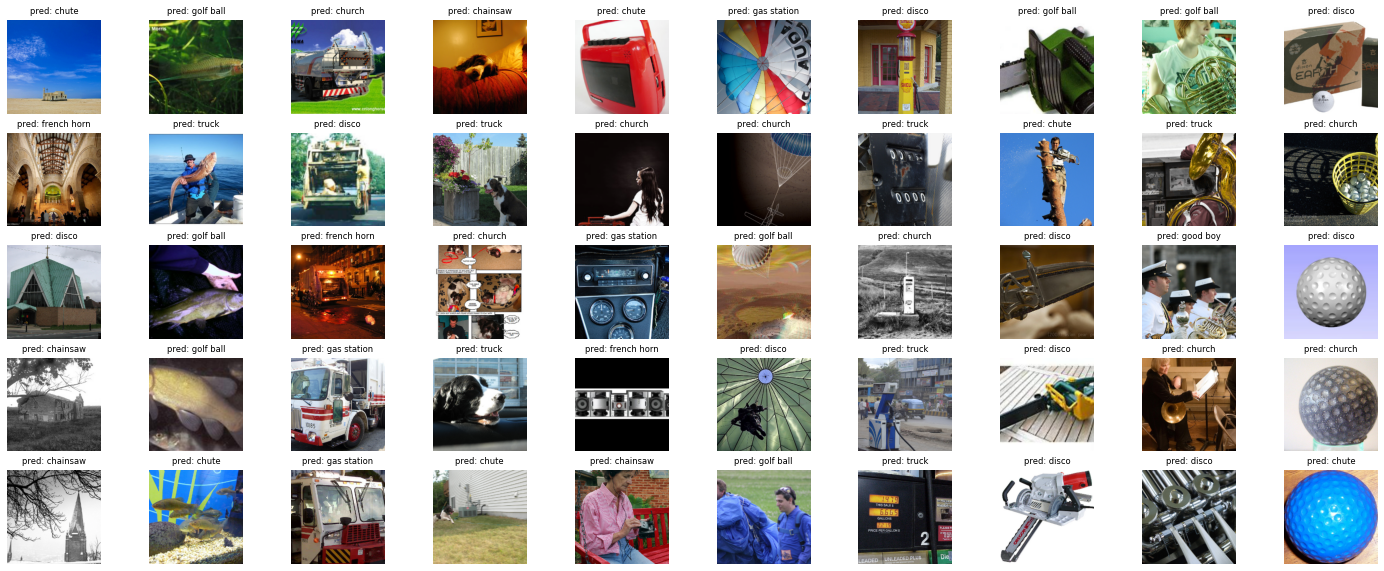

In [26]:
renorm = T.Compose(
    [
     T.Normalize(mean=(0,0,0), std = 1. / np.array(std)),
    T.Normalize(mean=-np.array(mean), std=(1., 1., 1.)), 
    T.ToPILImage(mode='RGB')
    ] 
    )

fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(25, 10))
for i in range(10):
    labels= mistake_labels[i]
    images = mistake_imgs[i]
    preds = mistake_preds[i]
    for j in range(5):
        ax[j, i].imshow(renorm(torch.tensor(images[j])))
        ax[j, i].set_title(f'pred: {class_names[preds[j]]}', fontsize='small')
        ax[j, i].axis('off')
    
plt.show();

In [57]:
def check_parameters():
    resnet18 = Resnet(out_dim=1000)
    my_18_param_cnt = resnet18.count_parameters()
    resnet18_torch = models.resnet18(pretrained=False)
    torch_18_param_cnt = sum(p.numel() for p in resnet18_torch.parameters() if p.requires_grad)
    print(f'torch resnet18 param: {torch_18_param_cnt}, custom resnet18 param: {my_18_param_cnt}')
    del resnet18
    del resnet18_torch
    
    resnet34 = Resnet(num_layers=34, out_dim=1000)
    my_34_param_cnt = resnet34.count_parameters()
    resnet34_torch = models.resnet34(pretrained=False)
    torch_34_param_cnt = sum(p.numel() for p in resnet34_torch.parameters() if p.requires_grad)
    print(f'torch resnet34 param: {torch_34_param_cnt}, custom resnet34 param: {my_34_param_cnt}')
    del resnet34
    del resnet34_torch
    
    resnet50 = Resnet(num_layers=50, out_dim=1000)
    my_50_param_cnt = resnet50.count_parameters()
    resnet50_torch = models.resnet50(pretrained=False)
    torch_50_param_cnt = sum(p.numel() for  p in resnet50_torch.parameters() if p.requires_grad)
    print(f'torch resnet50 param: {torch_50_param_cnt}, custom resnet50 param: {my_50_param_cnt}')
    del resnet50
    del resnet50_torch
    
    resnext = ResNext(out_dim=1000)
    my_resnext_param_cnt = resnext.count_parameters()
    resnext_torch = models.resnext50_32x4d(pretrained=False)
    resnext_torch_param_cnt = sum(p.numel() for  p in resnext_torch.parameters() if p.requires_grad)
    print(f'torch resnext param: {resnext_torch_param_cnt}, custom resnext param: {my_resnext_param_cnt}')
    del resnext
    del resnext_torch

In [58]:
check_parameters()

torch resnet18 param: 11689512, custom resnet18 param: 11689512
torch resnet34 param: 21797672, custom resnet34 param: 21797672
torch resnet50 param: 25557032, custom resnet50 param: 25557032
torch resnext param: 25028904, custom resnext param: 25028904
